# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) ARIMA Model

## Introduction

The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store- Walmart!

In this lab, we will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but we'll focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

1. Record any observed trends in the data
2. Produce a trained model to predict future sales numbers
3. Assemble your findings in a report

Try your best to tune your model. It's difficult!

## Exercise

#### Requirements

- Code along to the guidelines below
- Assemble observations and graphs supporting your model in a 1-2 page PDF

**Bonus:**
- Create a Tableau dashboard with various different views of the data and corresponding results of your models

#### Starter code

To setup the data:

```python
import pandas as pd
import numpy as np

%matplotlib inline

data = pd.read_csv('assets/datasets/train.csv')
data.set_index('Date', inplace=True)
data.head()
```

#### Deliverable

1. Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.
2. Plot the rolling_mean for `Weekly_Sales`. What general trends do you observe?
3. Compute the 1, 2, 52 autocorrelations for `Weekly_Sales` and/or create an autocorrelation plot.
4. What does the autocorrelation plot say about the type of model you want to build?
5. Split the weekly sales data in a training and test set - using 75% of the data for training
6. Create an AR(1) model on the training data and compute the mean absolute error of the predictions. How effective is this model?
7. Plot the residuals - where are their significant errors?
8. Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set?
9. Finally, compute an ARIMA model to improve your prediction error - iterate on the p, q, and parameters comparing the model's performance.
10. Assemble your findings, including any useful graphs, in a 1-2 page PDF.
11. Optional: if you finish and would like feedback, Slack your report to Winston.


#### Additional Resources

1. [ARMA Example](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/tsa_arma.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)


In [50]:
import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

%matplotlib inline

plt.rcParams['figure.figsize'] = (10,6)

In [30]:
import pandas as pd
import numpy as np

data = pd.read_csv('assets/datasets/train.csv')
#data = pd.read_csv('assets/datasets/train.csv', parse_dates='Dates')
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3+ MB


In [32]:
data.index = pd.to_datetime(data.index)

## Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.

In [57]:
store1_sales = data[data['Store'] == 1]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


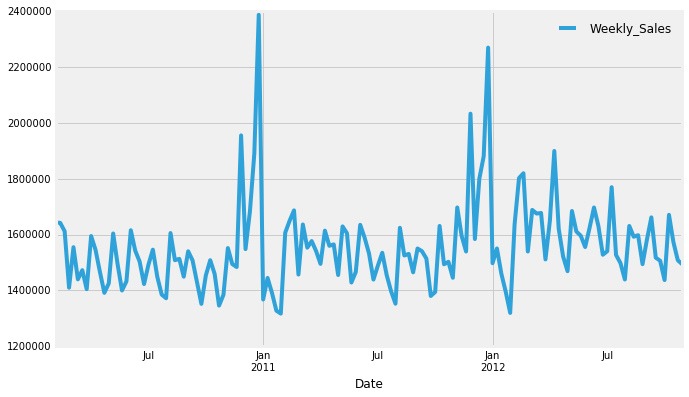

In [58]:
store1_sales[['Weekly_Sales']].resample('W', how = 'sum').plot()

## Plot the rolling_mean for Weekly_Sales. What general trends do you observe?

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


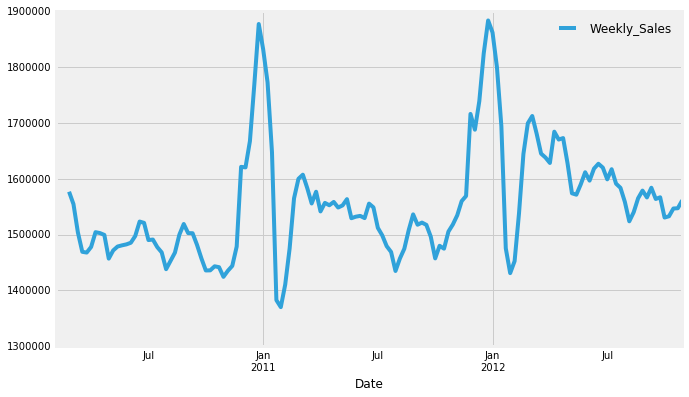

In [39]:
store1_sales[['Weekly_Sales']].resample('W', how = 'sum').rolling(4).mean().plot()

## Compute the 1, 2, 52 autocorrelations for Weekly_Sales and/or create an autocorrelation plot.

In [59]:
store1_total_sales = store1_sales['Weekly_Sales'].resample('W').sum()

In [60]:
# Autocorrelation for 1

store1_total_sales.autocorr(lag=1)

0.30215827941131251

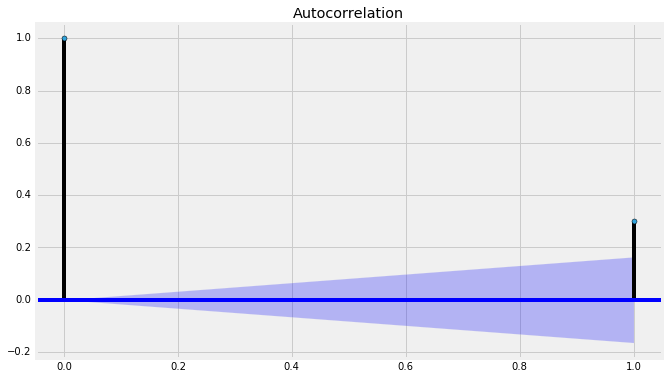

In [65]:
plot_acf(store1_total_sales, lags=1);

In [45]:
# Autocorrelation for 2
store1_sales['Weekly_Sales'].resample('W').sum().autocorr(lag=2)

0.12741313055390105

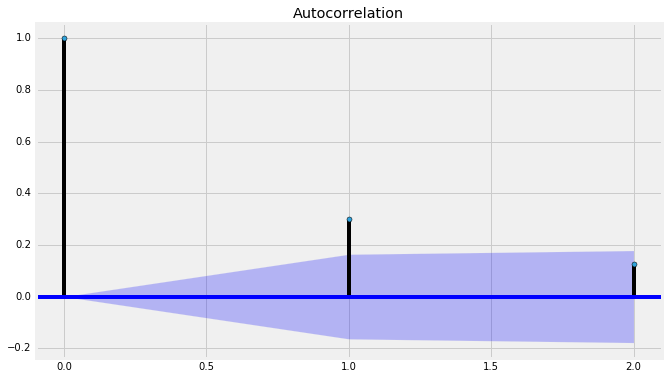

In [66]:
plot_acf(store1_total_sales, lags=2);

In [46]:
# Autocorrelation for 52
store1_sales['Weekly_Sales'].resample('W').sum().autocorr(lag=52)

0.89537602947770079

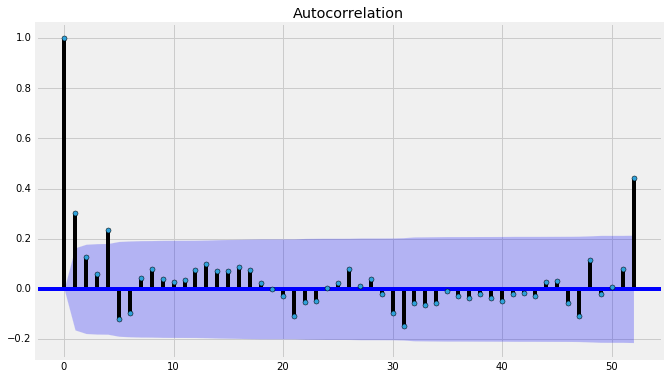

In [67]:
plot_acf(store1_total_sales, lags=52);

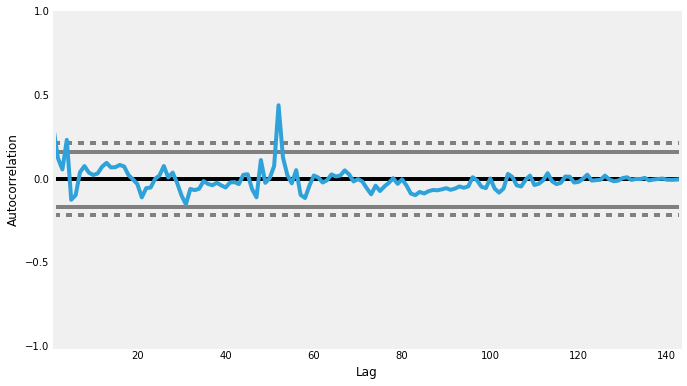

In [53]:
autocorrelation_plot(store1_sales[['Weekly_Sales']].resample('W').sum().Weekly_Sales);

## What does the autocorrelation plot say about the type of model you want to build?

We saw strong autocorrelation for 5 weeks and 52 weeks, i.e. monthly and yearly autocorrelation.

## Split the weekly sales data in a training and test set - using 75% of the data for training

In [135]:
store1_sales.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [139]:
int(round(0.8, 0))

1

In [141]:
# Train, test split using whole chunks of data i.e. week 0 to week 40

train_size = 0.75

train_index = int(round(train_size*len(store1_sales)))

In [143]:
train = store1_sales.iloc[:train_index, :]
test = store1_sales.iloc[train_index:, :]

In [121]:
cols = store1_sales.columns

In [73]:
store1_sales.iloc[0,:].values

array([1, 1, 24924.5, False], dtype=object)

In [81]:
4%2

0

In [114]:
train_weeks = 15
test_weeks = 5

train = []
test = []

count = 0

for i in range(len(store1_sales)):
    
    if count == 19:
        a = list(store1_sales.iloc[i,:].values)
        a.insert(0, store1_sales.index[i])
        test.append(a)
        count = 0
    else:
        
        if count < 15:
            a = list(store1_sales.iloc[i,:].values)
            a.insert(0, store1_sales.index[i])

            train.append(a)
            count += 1

        elif count < 20:
            a = list(store1_sales.iloc[i,:].values)
            a.insert(0, store1_sales.index[i])

            test.append(a)
            count += 1

In [115]:
len(store1_sales)

10244

In [144]:
len(train)

7683

In [145]:
len(test)

2561

In [127]:
cols.insert(0,'Date')

Index([u'Date', u'Store', u'Dept', u'Weekly_Sales', u'IsHoliday'], dtype='object')

In [131]:
train_df = pd.DataFrame(train)
train_df.columns = cols.insert(0,'Date')
train_df.index = train_df['Date']
del train_df['Date']
train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [133]:
train_df.index = pd.to_datetime(train_df.index)

In [132]:
test_df = pd.DataFrame(test)
test_df.columns = cols.insert(0,'Date')
test_df.index = test_df['Date']
del test_df['Date']
test_df.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-05-21,1,1,14773.04,False
2010-05-28,1,1,15580.43,False
2010-06-04,1,1,17558.09,False
2010-06-11,1,1,16637.62,False
2010-06-18,1,1,16216.27,False


In [134]:
test_df.index = pd.to_datetime(test_df.index)

## Create an AR(1) model on the training data and compute the mean absolute error of the predictions. How effective is this model?

## Plot the residuals - where are their significant errors?

## Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set?

## Finally, compute an ARIMA model to improve your prediction error - iterate on the p, q, and parameters comparing the model's performance.

## Assemble your findings, including any useful graphs, in a 1-2 page PDF.

## Optional: if you finish and would like feedback, Slack your report to Winston.